Epoch[1/25], G Loss: 0.1908, D Loss: 0.1931


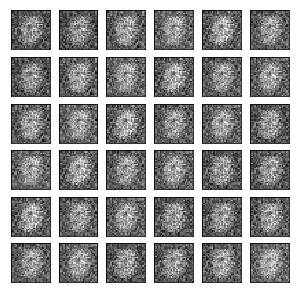

Epoch[2/25], G Loss: 0.2109, D Loss: 0.1554


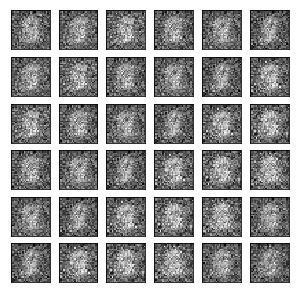

Epoch[3/25], G Loss: 0.1566, D Loss: 0.1582


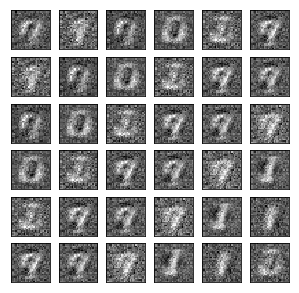

Epoch[4/25], G Loss: 0.1836, D Loss: 0.1612


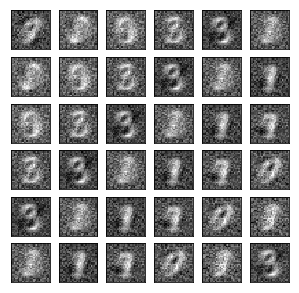

Epoch[5/25], G Loss: 0.2186, D Loss: 0.1359


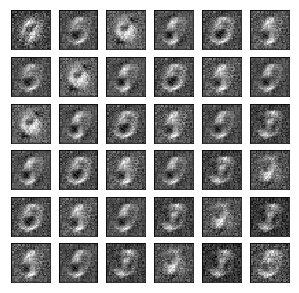

Epoch[6/25], G Loss: 0.2322, D Loss: 0.1308


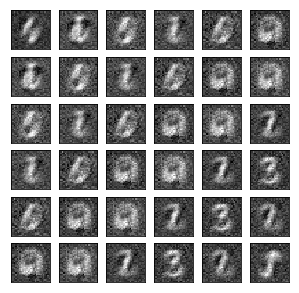

Epoch[7/25], G Loss: 0.2251, D Loss: 0.1457


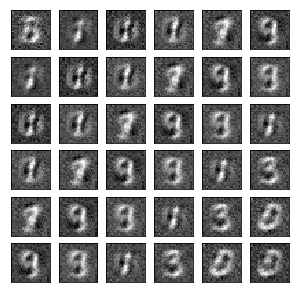

Epoch[8/25], G Loss: 0.2275, D Loss: 0.1325


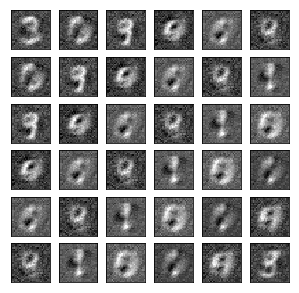

Epoch[9/25], G Loss: 0.2269, D Loss: 0.1400


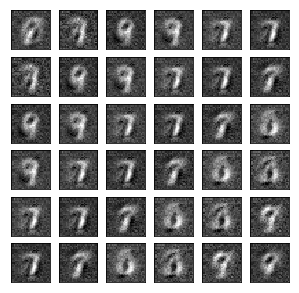

Epoch[10/25], G Loss: 0.2433, D Loss: 0.1361


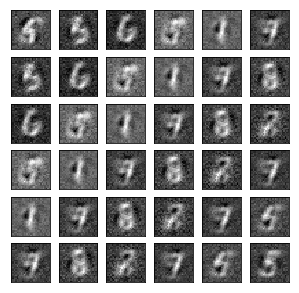

Epoch[11/25], G Loss: 0.2416, D Loss: 0.1245


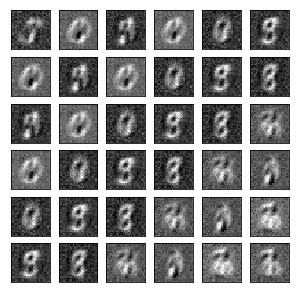

Epoch[12/25], G Loss: 0.2384, D Loss: 0.1329


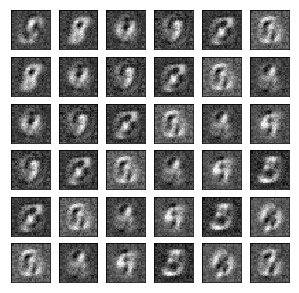

Epoch[13/25], G Loss: 0.2507, D Loss: 0.1217


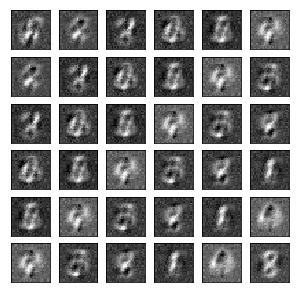

Epoch[14/25], G Loss: 0.2512, D Loss: 0.1234


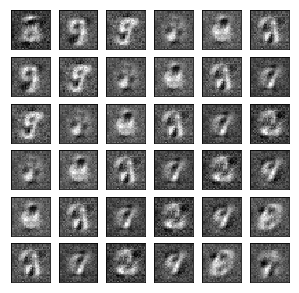

Epoch[15/25], G Loss: 0.2544, D Loss: 0.1213


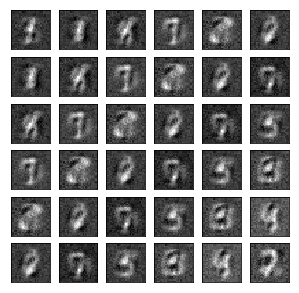

Epoch[16/25], G Loss: 0.2618, D Loss: 0.1133


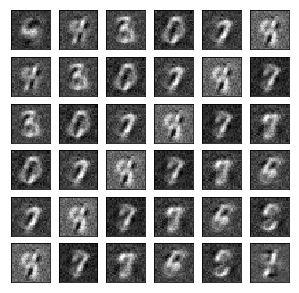

Epoch[17/25], G Loss: 0.2513, D Loss: 0.1230


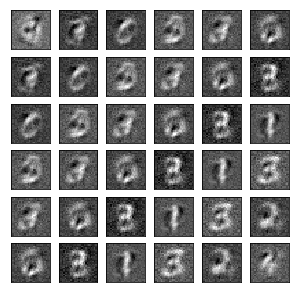

Epoch[18/25], G Loss: 0.2735, D Loss: 0.1095


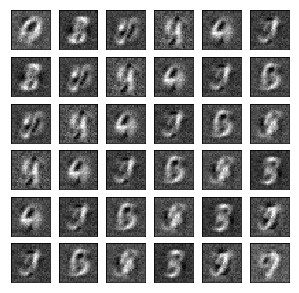

Epoch[19/25], G Loss: 0.2746, D Loss: 0.1067


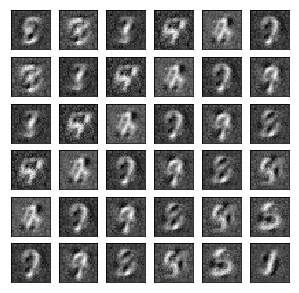

Epoch[20/25], G Loss: 0.2678, D Loss: 0.1150


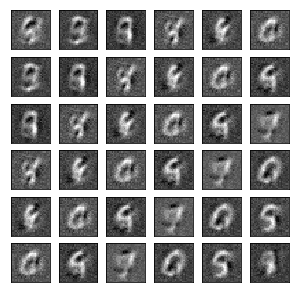

Epoch[21/25], G Loss: 0.2653, D Loss: 0.1197


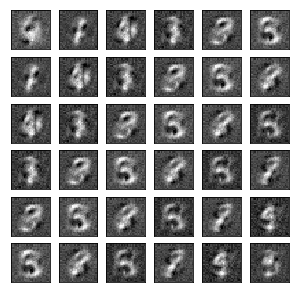

Epoch[22/25], G Loss: 0.2592, D Loss: 0.1241


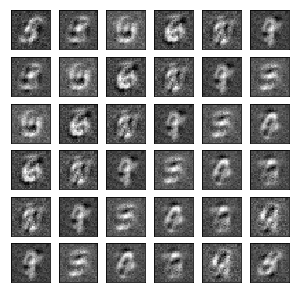

Epoch[23/25], G Loss: 0.2728, D Loss: 0.1136


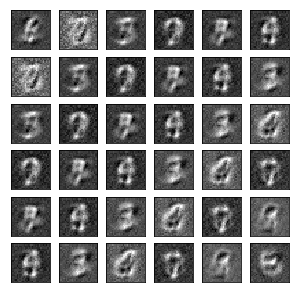

Epoch[24/25], G Loss: 0.2609, D Loss: 0.1289


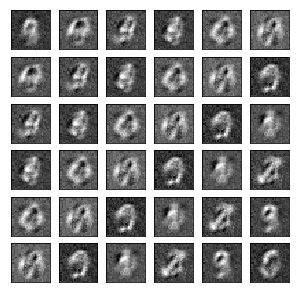

Epoch[25/25], G Loss: 0.2600, D Loss: 0.1300


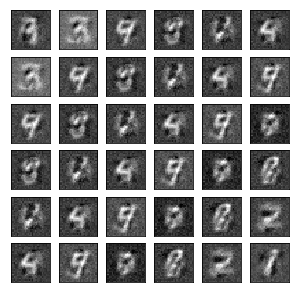

In [2]:
""" (WGAN GP)
Wasserstein GAN with Gradient Penalties ('improved methods for WGAN training')

https://arxiv.org/pdf/1704.00028.pdf

The output of WGAN's G is unbounded unless passed through an activation function. We use no such
acitivation function in this implementation. A sigmoid activation would make the images look much nicer,
faster for binary MNIST.

WGAN GP roposes a gradient penalty to add to the WGAN discriminator loss as an alternative method for enforcing 
the Lipschitz constraint (previously done via weight clipping). This penalty does not suffer from the biasing
of the discriminator toward simple funtions due to weight clipping. Additionally, the reformulation of the 
discriminator by adding a gradient penaltyterm makes batch normalization not necessary. This is notable because 
batch normalization implicitly changes the discriminator's problem from mapping one-to-one to many-to-many.
"""

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
from tqdm import tqdm_notebook
from load_data import get_data

def to_cuda(x):
    """ Cuda-erize a tensor """
    if torch.cuda.is_available():
        x = x.cuda()
    return x

# Enable Jupyter notebook plotting
%matplotlib inline

# Load in binarized MNIST data, separate into data loaders
train_iter, val_iter, test_iter = get_data()


class Generator(nn.Module):
    """ Generator. Input is noise, output is a generated image. 
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super().__init__()
        
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = self.generate(activated)
        return generation


class Discriminator(nn.Module):
    """ Critic (not trained to classify). Input is an image (real or generated), 
    output is approximate least-squares divergence.
    """
    def __init__(self, image_size, hidden_dim, output_dim):
        super().__init__()
        
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.sigmoid(self.discriminate(activated))
        return discrimination


class LSGAN(nn.Module):
    """ Super class to contain both Discriminator (D) and Generator (G) 
    """
    def __init__(self, image_size, hidden_dim, z_dim, output_dim=1):
        super().__init__()
        
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim


class Trainer:
    """ Object to hold data iterators, train a GAN variant 
    """
    def __init__(self, model, train_iter, val_iter, test_iter):
        self.model = to_cuda(model)
        self.name = model.__class__.__name__
        
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
        
        self.Glosses = []
        self.Dlosses = []

    def train(self, num_epochs, G_lr=1e-4, D_lr=1e-4, D_steps=1):
        """ Train a Wasserstein GAN with Gradient Penalty
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 5e-5)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 5e-5)
            D_steps: int, training step ratio for how often to train D compared to G (default 5)
        """
        # Initialize optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in self.model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in self.model.D.parameters() if p.requires_grad], lr=D_lr)
    
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs+1)):
            self.model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                for _ in range(D_steps): 

                    # Reshape images
                    images = self.process_batch(self.train_iter)

                    # TRAINING D: Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator to approximate the Wasserstein distance between real, generated
                    # distributions                    
                    D_loss = self.train_D(images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss.item())
                                                        
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator to (roughly) minimize the approximated Wasserstein distance
                G_loss = self.train_G(images)
                
                # Log results, update parameters
                G_losses.append(G_loss.item())
                G_loss.backward()
                G_optimizer.step()
            
            # Save progress
            self.Glosses.extend(G_losses)
            self.Dlosses.extend(D_losses)
                            
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses))) 
            
            # Visualize generator progress
            self.generate_images(epoch)
            plt.show()
        
    def train_D(self, images, a=0, b=1):
        """ Run 1 step of training for discriminator

        Input:
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: L2 loss for discriminator, 0.50 * E[(D(x) - a)^2] + 0.50 * E[(D(G(z)) - b)^2], 
                    where a and b are labels for generated (0) and real (1) data
        """ 
        # Sample noise, an output from the generator
        noise = self.compute_noise(images.shape[0], self.model.z_dim)
        G_output = self.model.G(noise)
        
        # Use the discriminator to sample real, generated images
        DX_score = self.model.D(images) # D(x)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # Compute L2 loss for D
        D_loss = (0.50 * torch.mean((DX_score - b)**2)) + (0.50 * torch.mean((DG_score - a)**2))
        
        return D_loss
    
    def train_G(self, images, c=1):
        """ Run 1 step of training for generator
        
        Input:
            images: batch of images (reshaped to [batch_size, -1])   
        Output:
            G_loss: L2 loss for G,  0.50 * E[(D(G(z)) - c)^2], 
                    where c is the label that G wants D to believe for fake data (i.e., 1)
        """   
        # Get noise, classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], self.model.z_dim) # z
        G_output = self.model.G(noise) # G(z)
        DG_score = self.model.D(G_output) # D(G(z))
        
        # Compute L2 loss for G,
        G_loss = 0.50 * torch.mean((DG_score - c)**2)
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_cuda(torch.randn(batch_size, z_dim))
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_cuda(images.view(images.shape[0], -1))
        return images
    
    def generate_images(self, epoch, num_outputs=36, save=True):
        """ Visualize progress of generator learning """
        # Turn off any regularization
        self.model.eval()
        
        # Sample noise vector
        noise = self.compute_noise(num_outputs, self.model.z_dim)
        
        # Transform noise to image
        images = self.model.G(noise)
        
        # Reshape to proper image size
        images = images.view(images.shape[0], 28, 28)
        
        # Plot
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        # Save images if desired
        if save:
            outname = '../viz/' + self.name + '/'
            if not os.path.exists(outname):
                os.makedirs(outname)
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), 
                                         outname + 'reconst_%d.png'
                                         %(epoch), nrow = 5)
    
    def viz_loss(self):
        """ Visualize loss for the generator, discriminator """
        plt.style.use('ggplot')
        plt.rcParams["figure.figsize"] = (8,6)

        plt.plot(self.Dlosses, 'r')
        plt.plot(self.Glosses, 'g')
        
        plt.legend(['Discriminator', 'Generator'])
        plt.title(self.name)
        plt.show()

    def save_model(self, savepath):
        """ Save model state dictionary """
        torch.save(self.model.state_dict(), savepath)
    
    def load_model(self, loadpath):
        """ Load state dictionary into model """
        state = torch.load(loadpath)
        self.model.load_state_dict(state)


model = LSGAN(image_size=784, 
              hidden_dim=256, 
              z_dim=128)

trainer = Trainer(model=model, 
                  train_iter=train_iter, 
                  val_iter=val_iter, 
                  test_iter=test_iter)

trainer.train(num_epochs=25,
              G_lr=1e-4,
              D_lr=1e-4,
              D_steps=1)